In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
boost_df = pd.read_csv('data/boost_df.csv')

In [3]:
boost_df.head()

,trip_id,timestamp,boost_number,boost_amount,base_plus_boost,claimed,total_price,base_price,total_driver_supply,metro_area,trip_start_date
0,1,2022-12-30 12:00:00,0,0.00,10.00,0,10.00,10.0,202,SFO,2023-01-01 00:00:00
1,1,2022-12-30 12:05:00,1,1.76,11.76,0,11.76,10.0,263,SFO,2023-01-01 00:00:00
2,1,2022-12-30 12:10:00,2,2.04,12.04,0,13.80,10.0,203,SFO,2023-01-01 00:00:00
3,1,2022-12-30 12:15:00,3,1.78,11.78,1,15.58,10.0,201,SFO,2023-01-01 00:00:00
4,2,2022-12-30 13:00:00,0,0.00,35.00,0,35.00,35.0,242,ATL,2023-01-01 01:00:00


In [4]:
boost_df[['trip_id', 'boost_number', 'metro_area']].groupby('trip_id').max().groupby('metro_area').mean()

,boost_number
metro_area,
ATL,5.082445
DEN,4.951773
DET,5.094822
DFW,5.109851
LAS,4.889706
LAX,4.994173
MCL,5.045175
MSP,4.839185
NYC,4.989422


In [5]:
claimed_df = boost_df[boost_df['claimed']==1]

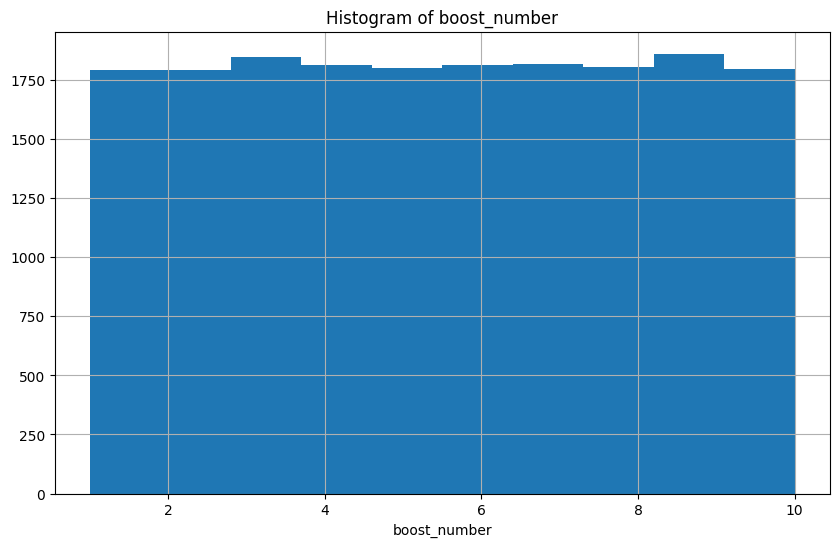

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(claimed_df['boost_number'])
plt.xlabel('boost_number')
plt.title(f'Histogram of {'boost_number'}')
plt.grid(True)
plt.show()

As pictured in the table and figure above, we have close to 5 boosts, on average, for each metro area, and we have an even distribution of the numbers of boosts - averaging out to 5 - for all claimed rides.

<Axes: >

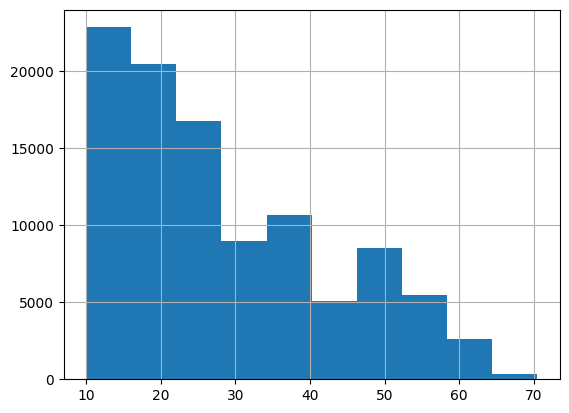

In [7]:
boost_df[boost_df['claimed']==0]['total_price'].hist()

In [8]:
boost_df[boost_df['claimed']==0]['total_price'].mean()

28.599687847177847

<Axes: >

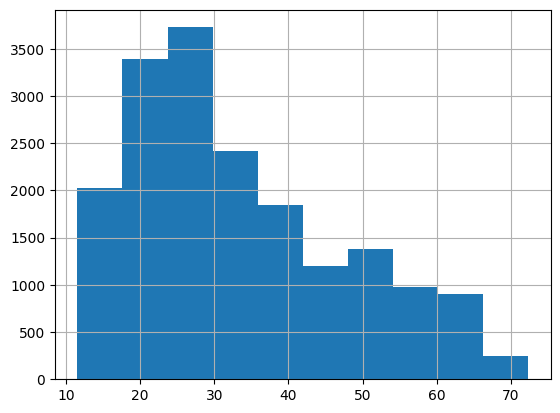

In [9]:
boost_df[boost_df['claimed']==1]['total_price'].hist()

In [10]:
boost_df[boost_df['claimed']==1]['total_price'].mean()

33.34225030349851

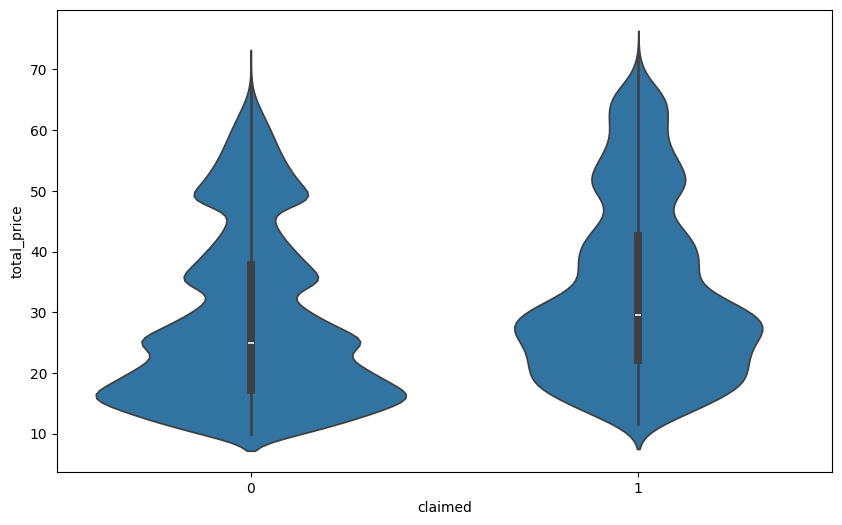

In [11]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='claimed', y='total_price', data=boost_df[['claimed', 'total_price']])
plt.show()

As we can see in the figures above, the total price is about 5 to 10 \$ higher on average for claimed rides

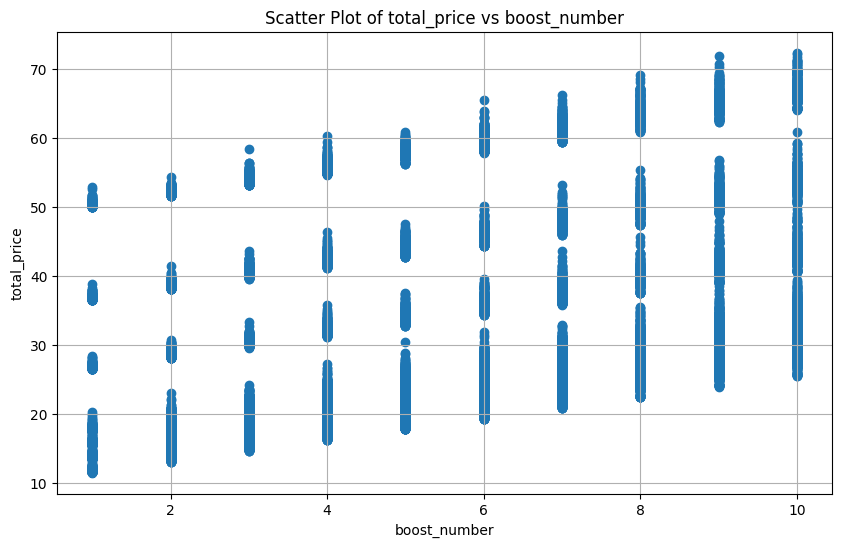

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(claimed_df['boost_number'], claimed_df['total_price'])
plt.xlabel('boost_number')
plt.ylabel('total_price')
plt.title(f'Scatter Plot of total_price vs boost_number')
plt.grid(True)
plt.show()

As expected, as the boost number goes up, so does the total price.

COLUMNS:
- trip day of week
- trip time of day
- time posted before trip
- time until claimed
- number of boosts (potential target)
- initial boost amount
- penultimate boost amount
- final boost amount
- total boost amount
- base price
- total price (potential target)
- initial driver supply
- penultimate driver supply
- final driver supply
- metro area

## DATA TRANSFORMATIONS

In [13]:
boost_df_by_trip = boost_df.groupby('trip_id').agg({
    'timestamp': list,
    'boost_number': 'max',
    'boost_amount': list,
    'total_price': 'max',
    'base_price': 'max',
    'total_driver_supply': list,
    'metro_area': 'last',
    'trip_start_date': 'last'
})

In [14]:
boost_df_by_trip['ride_posted_date'] = boost_df_by_trip['timestamp'].map(lambda x: x[0])
boost_df_by_trip['last_boost'] = boost_df_by_trip['timestamp'].map(lambda x: x[-1] if len(x)>1 else x[0])
boost_df_by_trip['first_boost_amount'] = boost_df_by_trip['boost_amount'].map(lambda x: x[0])
boost_df_by_trip['penultimate_boost_amount'] = boost_df_by_trip['boost_amount'].map(lambda x: x[-2] if len(x)>1 else x[0])
boost_df_by_trip['last_boost_amount'] = boost_df_by_trip['boost_amount'].map(lambda x: x[-1] if len(x)>1 else x[0])
boost_df_by_trip['original_driver_supply'] = boost_df_by_trip['total_driver_supply'].map(lambda x: x[0])
boost_df_by_trip['penultimate_driver_supply'] = boost_df_by_trip['total_driver_supply'].map(lambda x: x[-2] if len(x)>1 else x[0])
boost_df_by_trip['last_driver_supply'] = boost_df_by_trip['total_driver_supply'].map(lambda x: x[-1] if len(x)>1 else x[0])

In [15]:
# Convert to datetime
boost_df_by_trip['ride_posted_date'] = pd.to_datetime(boost_df_by_trip['ride_posted_date'])
boost_df_by_trip['last_boost'] = pd.to_datetime(boost_df_by_trip['last_boost'])
boost_df_by_trip['trip_start_date'] = pd.to_datetime(boost_df_by_trip['trip_start_date'])

# trip day of week
boost_df_by_trip['day_of_week'] = boost_df_by_trip['trip_start_date'].dt.dayofweek

# trip time of day
boost_df_by_trip['hour_of_day'] = boost_df_by_trip['trip_start_date'].dt.hour
boost_df_by_trip['hour_sin'] = np.sin(2 * np.pi * boost_df_by_trip['hour_of_day'] / 24)
boost_df_by_trip['hour_cos'] = np.cos(2 * np.pi * boost_df_by_trip['hour_of_day'] / 24)

# time posted before trip
boost_df_by_trip['time_to_ride_start'] = (boost_df_by_trip['trip_start_date'] - boost_df_by_trip['ride_posted_date']).dt.total_seconds() / 3600

# time until claimed
boost_df_by_trip['time_until_claimed'] = (boost_df_by_trip['last_boost'] - boost_df_by_trip['ride_posted_date']).dt.total_seconds() / 3600

# number of boosts (potential target)
boost_df_by_trip['boost_number']

# total boost amount
boost_df_by_trip['total_boost_amount'] = boost_df_by_trip['total_price'] - boost_df_by_trip['base_price']

# Handle categorical values
boost_df_by_trip = pd.get_dummies(boost_df_by_trip, columns=['metro_area', 'day_of_week'], drop_first=True, dtype=int)

# Drop columns used for transformations
boost_df_by_trip = boost_df_by_trip.drop(columns=[
    'timestamp', 
    'boost_amount', 
    'total_driver_supply', 
    'trip_start_date',
    'ride_posted_date',
    'last_boost',
    'hour_of_day'
])

In [16]:
boost_df_by_trip = boost_df_by_trip.drop('time_until_claimed', axis=1) # data leakage because each boost is 5 minutes
boost_df_by_trip = boost_df_by_trip.drop('total_boost_amount', axis=1) # data leakage because each boost is roughly the same amount
boost_df_by_trip = boost_df_by_trip.drop('total_price', axis=1) # this isn't known until the very end

In [17]:
boost_df_by_trip.to_csv('data/boost_model_dataset.csv', index=False)

In [18]:
boost_df_by_trip.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 1 to 20000
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   boost_number               20000 non-null  int64  
 1   base_price                 20000 non-null  float64
 2   first_boost_amount         20000 non-null  float64
 3   penultimate_boost_amount   20000 non-null  float64
 4   last_boost_amount          20000 non-null  float64
 5   original_driver_supply     20000 non-null  int64  
 6   penultimate_driver_supply  20000 non-null  int64  
 7   last_driver_supply         20000 non-null  int64  
 8   hour_sin                   20000 non-null  float64
 9   hour_cos                   20000 non-null  float64
 10  time_to_ride_start         20000 non-null  float64
 11  metro_area_DEN             20000 non-null  int64  
 12  metro_area_DET             20000 non-null  int64  
 13  metro_area_DFW             20000 non-null  int64  


In [19]:
boost_df_by_trip.describe()

,boost_number,base_price,first_boost_amount,penultimate_boost_amount,last_boost_amount,original_driver_supply,penultimate_driver_supply,last_driver_supply,hour_sin,hour_cos,...,metro_area_SDF,metro_area_SFO,metro_area_STL,metro_area_TPA,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
count,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,2.000000e+04,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,4.991750,23.070250,0.0,1.530597,1.701033,210.072150,210.443100,209.687450,2.631901e-04,2.019529e-04,...,0.072850,0.072050,0.067450,0.070250,0.142800,0.142800,0.142800,0.142800,0.142800,0.143200
std,3.168735,13.263237,0.0,0.777406,0.620313,160.012163,160.102253,158.540992,7.071397e-01,7.071091e-01,...,0.259897,0.258577,0.250806,0.255574,0.349878,0.349878,0.349878,0.349878,0.349878,0.350285
min,0.000000,10.000000,0.0,0.000000,0.000000,72.000000,72.000000,72.000000,-1.000000e+00,-1.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,12.000000,0.0,1.590000,1.640000,125.000000,126.000000,125.000000,-7.071068e-01,-7.071068e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,16.000000,0.0,1.740000,1.770000,166.000000,166.000000,166.000000,1.224647e-16,6.123234e-17,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,35.000000,0.0,1.920000,1.960000,221.000000,221.000000,222.000000,7.071068e-01,7.071068e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,48.500000,0.0,6.280000,4.910000,899.000000,899.000000,899.000000,1.000000e+00,1.000000e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


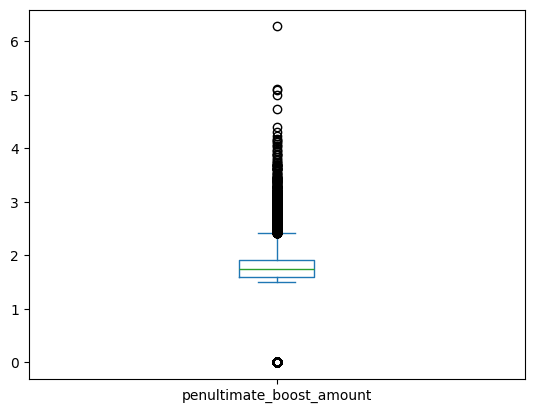

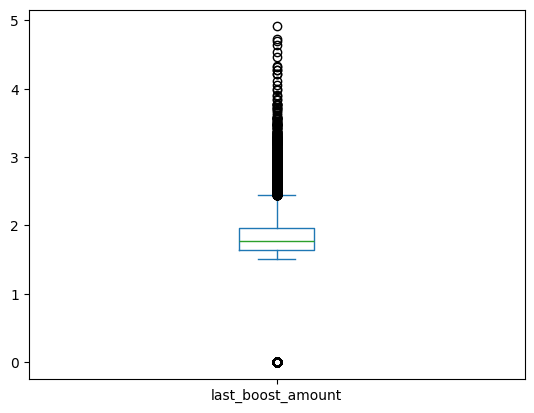

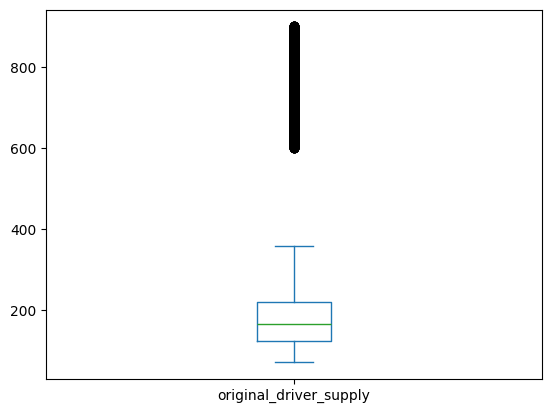

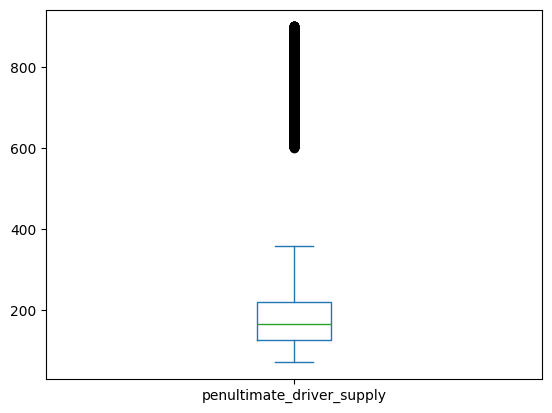

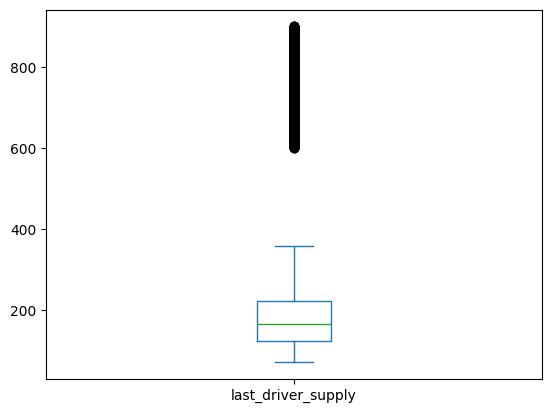

In [20]:
for col in ['penultimate_boost_amount', 'last_boost_amount', 'original_driver_supply', 'penultimate_driver_supply', 'last_driver_supply']:
    boost_df_by_trip[col].plot(kind='box')
    plt.show()

## Random Forest Regressor Model predicting number of boosts

In [21]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

X = boost_df_by_trip.drop('boost_number', axis=1)
y = boost_df_by_trip.boost_number

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

results_df = X_test.copy()
results_df['pred_boost_number'] = y_pred
results_df['actual_boost_number'] = y_test

Mean Squared Error: 5.6702133
Root Mean Squared Error: 2.3812209683269634


In [22]:
results_df

,base_price,first_boost_amount,penultimate_boost_amount,last_boost_amount,original_driver_supply,penultimate_driver_supply,last_driver_supply,hour_sin,hour_cos,time_to_ride_start,...,metro_area_STL,metro_area_TPA,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,pred_boost_number,actual_boost_number
trip_id,,,,,,,,,,,,,,,,,,,,,
10651,35.0,0.0,1.60,1.54,311,299,358,-1.000000,-1.836970e-16,36.0,...,0,0,1,0,0,0,0,0,4.98,6
2042,10.0,0.0,1.91,2.26,140,116,110,0.258819,9.659258e-01,36.0,...,0,0,0,0,0,0,0,0,5.52,10
8669,10.0,0.0,1.65,1.62,842,833,742,0.866025,5.000000e-01,36.0,...,0,0,0,0,1,0,0,0,5.07,4
1115,25.0,0.0,1.92,1.71,110,118,111,0.500000,-8.660254e-01,36.0,...,0,0,0,0,1,0,0,0,6.67,9
13903,10.0,0.0,0.00,0.00,108,108,108,1.000000,6.123234e-17,36.0,...,0,0,0,0,0,1,0,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465,14.0,0.0,0.00,0.00,177,177,177,0.000000,1.000000e+00,36.0,...,0,1,0,0,1,0,0,0,0.00,0
15657,16.0,0.0,1.81,1.70,136,139,146,0.866025,-5.000000e-01,36.0,...,0,1,0,0,0,0,0,0,6.80,3
19147,14.0,0.0,1.93,1.76,228,184,207,-1.000000,-1.836970e-16,36.0,...,0,0,0,0,0,0,1,0,5.44,4


In [23]:
feature_importances = rf_reg.feature_importances_

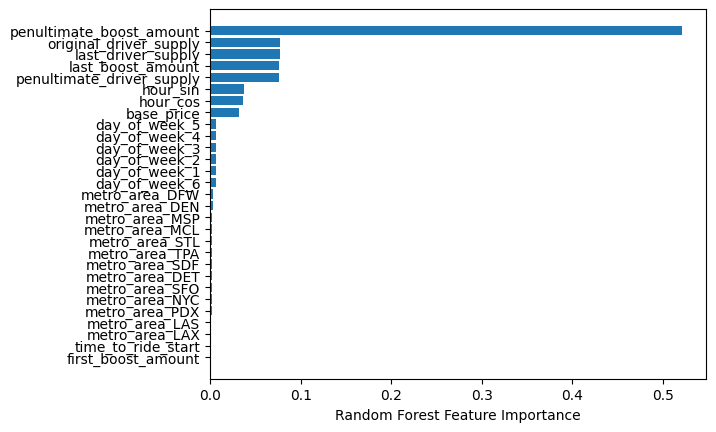

In [24]:
sorted_idx = feature_importances.argsort()

plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

## Potential Future Work

- A better way to do it could be to have a baseline model and a boost impact model
- First model without any boost info
- Second model, using the probability of the first model, to get a new likelihood
- Start with predicting likelihood within 3 boosts - can change this to see impact
- Use boost info to figure out if this is likely

In [25]:
df_no_boost = boost_df_by_trip.copy()
df_no_boost = df_no_boost[['base_price',
                           'original_driver_supply', 
                           'hour_sin', 
                           'hour_cos', 
                           'time_to_ride_start',
                           'metro_area_DEN',
                           'metro_area_DET', 
                           'metro_area_DFW', 
                           'metro_area_LAS', 
                           'metro_area_LAX',
                           'metro_area_MCL', 
                           'metro_area_MSP', 
                           'metro_area_NYC', 
                           'metro_area_PDX',
                           'metro_area_SDF', 
                           'metro_area_SFO', 
                           'metro_area_STL', 
                           'metro_area_TPA',
                           'day_of_week_1', 
                           'day_of_week_2', 
                           'day_of_week_3', 
                           'day_of_week_4',
                           'day_of_week_5', 
                           'day_of_week_6',
                           'boost_number']]

In [26]:
df_no_boost

,base_price,original_driver_supply,hour_sin,hour_cos,time_to_ride_start,metro_area_DEN,metro_area_DET,metro_area_DFW,metro_area_LAS,metro_area_LAX,...,metro_area_SFO,metro_area_STL,metro_area_TPA,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,boost_number
trip_id,,,,,,,,,,,,,,,,,,,,,
1,10.0,202,0.000000,1.000000e+00,36.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,3
2,35.0,242,0.258819,9.659258e-01,36.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
3,14.0,92,0.500000,8.660254e-01,36.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,10
4,25.0,144,0.707107,7.071068e-01,36.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,3
5,48.5,128,0.866025,5.000000e-01,36.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,10.0,214,0.707107,7.071068e-01,36.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
19997,12.0,243,0.866025,5.000000e-01,36.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
19998,12.0,165,0.965926,2.588190e-01,36.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2


In [27]:
df_no_boost['claimed_within_3'] = df_no_boost['boost_number'].apply(lambda x: 1 if x <= 3 else 0)

In [28]:
boost_number = df_no_boost['boost_number']

In [29]:
df_no_boost = df_no_boost.drop('boost_number', axis=1)

In [30]:
df_no_boost

,base_price,original_driver_supply,hour_sin,hour_cos,time_to_ride_start,metro_area_DEN,metro_area_DET,metro_area_DFW,metro_area_LAS,metro_area_LAX,...,metro_area_SFO,metro_area_STL,metro_area_TPA,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,claimed_within_3
trip_id,,,,,,,,,,,,,,,,,,,,,
1,10.0,202,0.000000,1.000000e+00,36.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
2,35.0,242,0.258819,9.659258e-01,36.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,14.0,92,0.500000,8.660254e-01,36.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,25.0,144,0.707107,7.071068e-01,36.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
5,48.5,128,0.866025,5.000000e-01,36.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,10.0,214,0.707107,7.071068e-01,36.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
19997,12.0,243,0.866025,5.000000e-01,36.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
19998,12.0,165,0.965926,2.588190e-01,36.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [31]:
len(df_no_boost[df_no_boost['claimed_within_3']==1])/len(df_no_boost)

0.36525

In [32]:
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)


X = df_no_boost.drop('claimed_within_3', axis=1)
y = df_no_boost.claimed_within_3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.57


In [33]:
results_df = X_test.copy()
results_df['claimed_within_3_pred'] = y_pred
results_df['claimed_within_3_actual'] = y_test
results_df.join(boost_number.to_frame(), how='left')

,base_price,original_driver_supply,hour_sin,hour_cos,time_to_ride_start,metro_area_DEN,metro_area_DET,metro_area_DFW,metro_area_LAS,metro_area_LAX,...,metro_area_TPA,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,claimed_within_3_pred,claimed_within_3_actual,boost_number
trip_id,,,,,,,,,,,,,,,,,,,,,
10651,35.0,311,-1.000000,-1.836970e-16,36.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
2042,10.0,140,0.258819,9.659258e-01,36.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
8669,10.0,842,0.866025,5.000000e-01,36.0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,4
1115,25.0,110,0.500000,-8.660254e-01,36.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,9
13903,10.0,108,1.000000,6.123234e-17,36.0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465,14.0,177,0.000000,1.000000e+00,36.0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
15657,16.0,136,0.866025,-5.000000e-01,36.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,3
19147,14.0,228,-1.000000,-1.836970e-16,36.0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,4
